In [1]:
import sys
import datetime as dt
sys.path.insert(0,'../..')
import matplotlib.pyplot as plt
from rivapy.instruments import ZeroCouponBondSpecification, FixedRateBondSpecification, PlainVanillaCouponBondSpecification
from rivapy.instruments.factory import create
from rivapy.tools.enums import DayCounterType, RollConvention, SecuritizationLevel, Currency
from rivapy.pricing import bond_pricing
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/doeltz/doeltz/development/RiVaPy/notebooks/instruments/../../rivapy/__init__.py:8: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [2]:
from collections.abc import Callable
import datetime as dt
import pandas as pd
import rivapy.tools.interfaces as interfaces
from rivapy.instruments.factory import create as _instrument_create
from rivapy.marketdata.factory import create as _marketdata_create

class MemoryStorage:
    def __init__(self, create: Callable[[dict], object]):
        self._store = {}
        self.create = create
        
    def add(self, instrument: interfaces.FactoryObject):
        if instrument.obj_id in self._store.keys():
            tmp = self._store[instrument.obj_id][-1]
            ins_dict = instrument.to_dict()
            if interfaces.FactoryObject.hash_for_dict(tmp) != interfaces.FactoryObject.hash_for_dict(ins_dict):
                self._store[instrument.obj_id].append(ins_dict)
        else:
            self._store[instrument.obj_id] = [instrument.to_dict()]
            
    def get_by_id(self, obj_id: str):
        if obj_id in self._store.keys():
            return self.create(self._store[obj_id][-1])
        else:
            raise Exception('No instrument with id ' + obj_id + ' exists in storage.')
        
    def _append_values(self, results: dict, keys: list):
        for k,v in self._store.items():
            obj = v[-1]
            for r in results.keys():
                if r == 'num_version':
                    results[r].append(len(v))
                else:
                    results[r].append(obj.get(r))
        
    def get_object_list(self, keys=['obj_id', 'cls', 'expiry', 'issue_date' ]):
        num_version = []
        tmp ={k:[] for k in keys}
        tmp['num_version'] = []
        self._append_values(tmp, keys)
        return pd.DataFrame(tmp)

In [3]:
ins_store = MemoryStorage(_instrument_create)
mkt_store = MemoryStorage(_marketdata_create)

In [4]:
for days in range (30,90, 30):
    bond = ZeroCouponBondSpecification('BOND_'+str(days), issue_date = dt.datetime(2023,1,1), maturity_date=dt.datetime(2023,1,1) + dt.timedelta(days=days), 
                              currency=Currency.EUR, notional=10.0, issuer='Depp2', 
                            securitization_level=SecuritizationLevel.SUBORDINATED)
    ins_store.add(bond)
    
ins_store.add(PlainVanillaCouponBondSpecification('PV_BOND_'+str(days), 
                                     issue_date = dt.datetime(2023,1,1),
                                     maturity_date=dt.datetime(2025,1,2), 
                                    currency=Currency.EUR, notional=1.0, 
                                     issuer='Depp', 
                                    securitization_level=SecuritizationLevel.SUBORDINATED, 
                                    coupon = 0.05, coupon_freq='1Y', accrual_start = dt.datetime(2023,2,10)))

In [15]:
bond_spec = PlainVanillaCouponBondSpecification('PV_BOND_'+str(days), 
                                     issue_date = dt.datetime(2023,1,1),
                                     maturity_date=dt.datetime(2025,1,2), 
                                    currency=Currency.EUR, notional=1.0, 
                                     issuer='Depp', 
                                    securitization_level=SecuritizationLevel.SUBORDINATED, 
                                    coupon = 0.05, coupon_freq='1Y', accrual_start = dt.datetime(2023,2,10))
bond_spec.expected_cashflows()

TypeError: can't compare datetime.datetime to datetime.date

In [10]:
bond_pricing.SimpleCashflowPricer.compute_yield(target_dirty_price=100.0, val_date = dt.datetime(2023,5,1), specification=bond_spec)

TypeError: can't compare datetime.datetime to datetime.date

In [6]:
pv_bond.expected_cashflows()

[(datetime.datetime(2023, 2, 10, 0, 0), 0.0),
 (datetime.date(2024, 1, 2), 0.05),
 (datetime.date(2025, 1, 2), 0.05),
 (datetime.date(2025, 1, 2), 1.0)]

In [7]:
pv_bond.to_dict()

{'accrual_start': datetime.datetime(2023, 2, 10, 0, 0),
 'coupon_freq': '1Y',
 'coupon': 0.05,
 'obj_id': 'PV_BOND_60',
 'issuer': 'Depp',
 'securitization_level': 'SUBORDINATED',
 'issue_date': datetime.date(2023, 1, 1),
 'maturity_date': datetime.date(2025, 1, 2),
 'currency': 'EUR',
 'notional': 1.0,
 'cls': 'PlainVanillaCouponBondSpecification'}

In [8]:
ins_store.get_object_list(keys=['obj_id', 'cls', 'maturity_date', 'issue_date', 'issuer', 'securitisation_level' ])

,obj_id,cls,maturity_date,issue_date,issuer,securitisation_level,num_version
0,BOND_30,ZeroCouponBondSpecification,2023-01-31,2023-01-01,Depp2,None,1
1,BOND_60,ZeroCouponBondSpecification,2023-03-02,2023-01-01,Depp2,None,1
2,PV_BOND_60,PlainVanillaCouponBondSpecification,2025-01-02,2023-01-01,Depp,None,1


In [17]:
from rivapy.marketdata.curves import NelsonSiegel, DiscountCurveParametrized

ns = NelsonSiegel(beta0=0.1, beta1 = 0.02, beta2=0.1, tau=1.0)
dc = DiscountCurveParametrized('DC',  refdate = dt.datetime(2023,1,1), rate_parametrization=ns, 
                               daycounter = DayCounterType.Act365Fixed)
#mkt_store.add(dc)

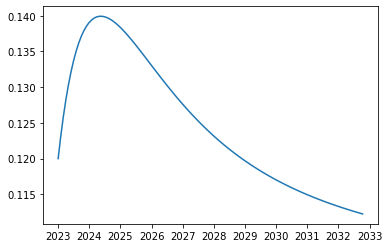

In [19]:
mkt_store.get_by_id('DC')
dates = [dt.datetime(2023,1,1) + dt.timedelta(days=30*days) for days in range(120)]
values = [dc.value(refdate = dt.datetime(2023,1,1),d=d) for d in dates]
plt.plot(dates, values)